In [1]:
# Launch 7 parallel processes and load module in all
addprocs(7)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot, HDF5, JLD

# Qubit Zeno Dragging Simulation

**Justin Dressel**, Jan 4, 2017 <br />
*Institute for Quantum Studies, Chapman University*

Simulate Zeno dragging for a single qubit (in its rotating frame), with realistic parameters used by the UC Berkeley team (courtesy of Shay Hacohen-Gourgy).

## Problem Parameters

Consider a qubit initially in its ground state that is being continuously measured along a slowly drifting axis.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
Γ = 2π * 0.13;   # Total dephasing rate per measurement channel (MHz, 1.2μs decay time)
η1 = 0.49;       # Quantum efficiency of channel 1
η2 = 0.40;       # Quantum efficiency of channel 2
τ1 = 1/(2*Γ*η1); # Collapse timescale for channel 1
τ2 = 1/(2*Γ*η2); # Collapse timescale for channel 2
T = (0.0, 2.0);  # Time duration of simulation (in μs)
Δt = 0.001;      # Time discretization (1ns)

# Hamiltonian: no residual oscillations in x-z plane
H = (0.0).*q("y");

# Residual dephasing from rotating frame (at rate 0.0064 MHz, 25μs decay time)
ΓR = 2π * 0.0064;
DR = sqrt(ΓR/2).*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sols; plot_title="Zeno-dragged Trajectory", bloch=true, blochplane=true, readout=false, ch2=false, stds=[])
    # Plot Bloch components vs. time
    if bloch
        figure(1)
        ax = gca()
        ax[:set_ylim]([-1.1,1.1])
        hold(true)
        for sol in sols
            plot(sol[1].t, sol[1], label=L"$x$", color="r", alpha=0.8, antialiased=true)
            plot(sol[2].t, sol[2], label=L"$z$", color="g", alpha=0.8, antialiased=true)
            if length(stds) > 0
                fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
                fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
            end
        end
        xlabel(L"$t\,(\mu s)$")
        ylabel("Bloch coordinates")
        title(plot_title)
        legend()
        hold(false)
        show()
    end
    # Plot Bloch x-z plane
    if blochplane
        figure(2)
        hold(true)
        tt = linspace(0,2π,100)
        plot(cos(tt), sin(tt), color="k", linestyle="--")
        for sol in sols
            plot(sol[1], sol[2], alpha=0.8, antialiased=true)
        end
        ax = gca()
        ax[:set_ylim]([-1.1,1.1])
        ax[:set_xlim]([-1.1,1.1])
        ax[:set_aspect]("equal")
        grid(true)
        xlabel(L"$x$")
        ylabel(L"$z$")
        title(plot_title*" Bloch Plane")
        show()
    end
    # Plot Readouts
    if readout
        figure(3)
        hold(true)
        for sol in sols
            plot(sol[3].t, sol[3], label=L"$r_z$", color="r", alpha=0.8, antialiased=true)
            ch2 && plot(sol[4].t, sol[4], label=L"$r_\phi$", color="g", alpha=0.8, antialiased=true)
            if length(stds) > 0
                fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="r", alpha=0.2, antialiased=true)
                ch2 && fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="g", alpha=0.2, antialiased=true)
            end
        end
        xlabel(L"$t\,(\mu s)$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = \frac{\Gamma_R}{2}\left[\sigma_y\,\rho\,\sigma_y^\dagger - \frac{\{\sigma_y^\dagger\sigma_y,\, \rho\}}{2}\right] + \frac{\Gamma}{2}\left[\sigma_z(t)\,\rho\,\sigma_z(t)^\dagger - \frac{\{\sigma_z(t)^\dagger\sigma_z(t),\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_\phi(t)$ if the second measurement channel is operating. Here the dragged measurement operators have the form:
$$ \sigma_z(t) = \cos(\Omega t)\, \sigma_z - \sin(\Omega t)\, \sigma_x $$
$$ \sigma_\phi(t) = \cos(\Omega t + \phi)\, \sigma_z - \sin(\Omega t + \phi)\, \sigma_x $$
The residual dephasing is $\Gamma_R/2\pi = 0.04$MHz. The measurement dephasing per channel is $\Gamma/2\pi = 0.13$MHz.

In [5]:
# Dragging measurement channel 1 at frequency Ω
D1(Ω) = t -> sqrt(Γ/2).*( cos(Ω*t).*q("z") - sin(Ω*t).*q("x") )

# Dragging measurement channel 2 at frequency Ω, offset by angle ϕ
D2(ϕ, Ω) = t -> sqrt(Γ/2).*( cos(Ω*t + ϕ).*q("z") - sin(Ω*t + ϕ).*q("x") )

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(Ω=2π*0.01; T=T, ch2=false, ϕ=0.0, verbose=true)
    inc = lind(Δt, H, clist=[DR], flist=[D1(Ω)])
    ch2 && (inc = lind(Δt, H, clist=[DR], flist=[D1(Ω), D2(ϕ,Ω)]))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose)
end;

The plots below are for verification against existing Lindblad evolution code, to double-check that parameters are set correctly.

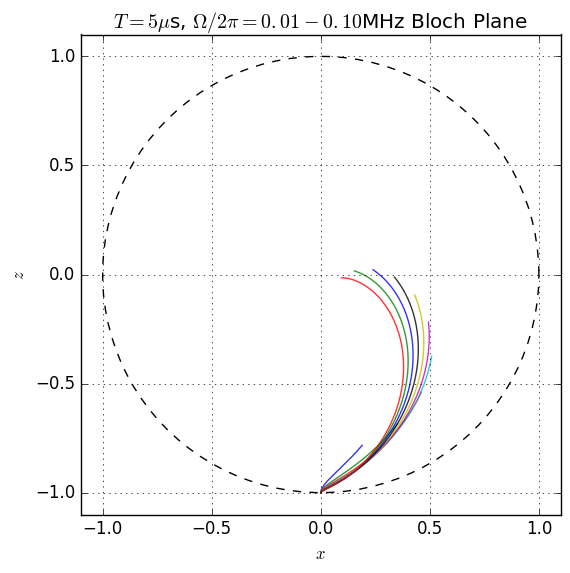

In [6]:
sols = [ensemble_average(2π*k, T=(0.0, 5.0), verbose=false) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=5\mu$s, $\Omega/2\pi=0.01-0.10$MHz")

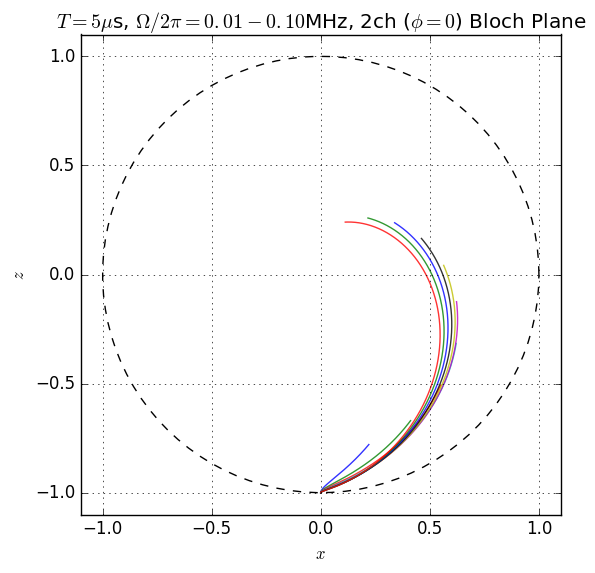

In [7]:
sols = [ensemble_average(2π*k, T=(0.0, 5.0), verbose=false, ch2=true) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=5\mu$s, $\Omega/2\pi=0.01-0.10$MHz, 2ch ($\phi=0$)")

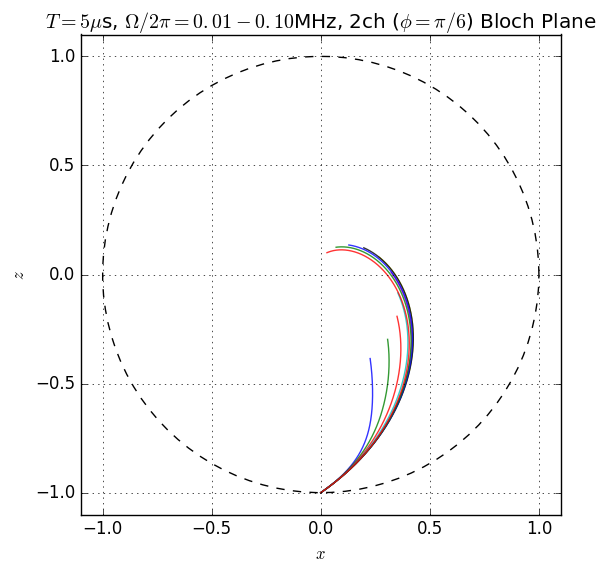

In [8]:
sols = [ensemble_average(2π*k, T=(0.0, 5.0), verbose=false, ch2=true, ϕ=π/6) for k in 0.01:0.01:0.10]
plot_solution(sols, bloch=false, plot_title=L"$T=5\mu$s, $\Omega/2\pi=0.01-0.10$MHz, 2ch ($\phi=\pi/6$)")

## Stochastic Dynamics

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = \frac{\Gamma_R}{2}\left[\sigma_y\,\rho\,\sigma_y^\dagger - \frac{\{\sigma_y^\dagger\sigma_y,\, \rho\}}{2}\right] + \frac{\Gamma}{2}\left[\sigma_z(t)\,\rho\,\sigma_z(t)^\dagger - \frac{\{\sigma_z(t)^\dagger\sigma_z(t),\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{2}}\left[\sigma_z(t)\,\rho + \rho\,\sigma_z(t)^\dagger - \langle\sigma_z(t)+\sigma_z(t)^\dagger\rangle\,\rho\right]dW $$
The last two (measurement) terms are duplicated in the case of two measurement channels.

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z(t) $$
corresponding to the measured observable. This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -\, \frac{dt\,(r-A)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the residual dephasing, yielding the completely positive map:
$$ \rho(t+dt) = \frac{\Gamma_R\,dt}{2}\,\sigma_y\,M_r\,\rho(t)\,M_r^\dagger\,\sigma_y + \frac{\gamma\,dt}{2}\,A\,M_r\,\rho(t)\,M_r^\dagger\,A^\dagger + \sqrt{1 - \frac{\gamma\,dt}{2}A^\dagger A - \frac{\Gamma_R\,dt}{2}\sigma_y^2}\,M_r\,\rho(t)\,M_r^\dagger\,\sqrt{1 - \frac{\gamma\,dt}{2}A^\dagger A - \frac{\Gamma_R\,dt}{2}\sigma_y^2} $$

In [9]:
# Dragging measurement channel 1 at frequency Ω
A1(Ω) = t -> cos(Ω*t).*q("z") - sin(Ω*t).*q("x")

# Dragging measurement channel 2 at frequency Ω, offset by angle ϕ
A2(ϕ, Ω) = t -> cos(Ω*t + ϕ).*q("z") - sin(Ω*t + ϕ).*q("x")

function ensemble_realization(Ω=2π*0.01; n=1, ch2=false, ϕ=0.0, verbose=true, T=(0.0, 4.0))
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, mflist=[(A1(Ω), τ1, η1)], clist=[DR])
    ch2 && (inc = meas(Δt, H, mflist=[(A1(Ω), τ1, η1), (A2(ϕ, Ω), τ2, η2)], clist=[DR]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    end
end;

### Single Trajectory Examples

#### Single-channel drag, 50kHz

INFO: Trajectory: steps = 4999, points = 4999, values = 2
INFO: Readout: values = 1


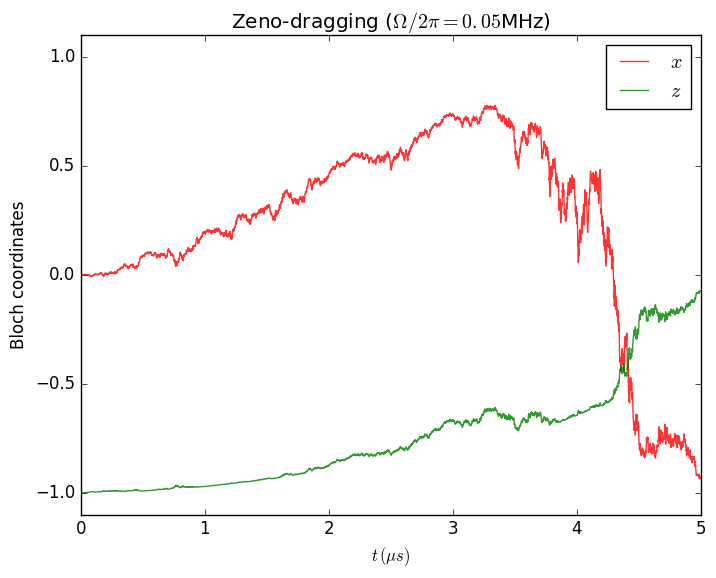

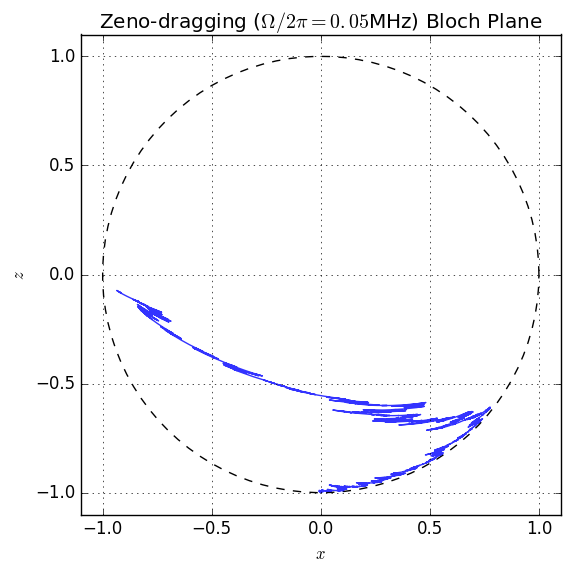

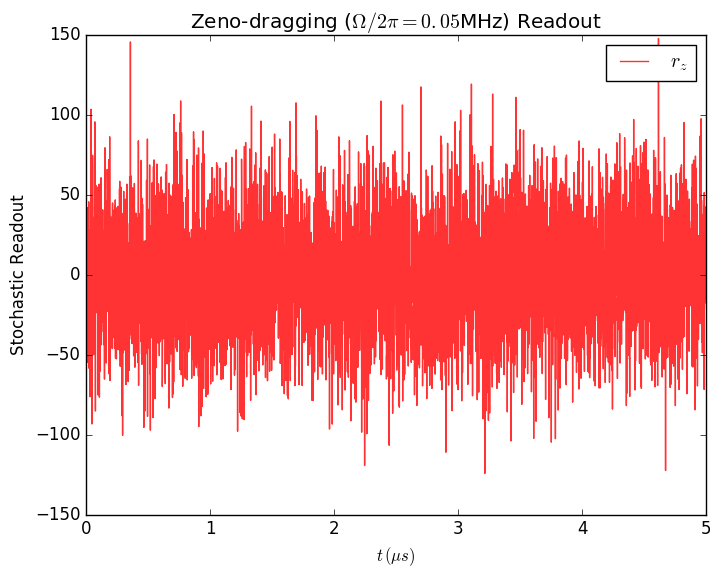

INFO: Time elapsed: 1.877671537 s, Steps per second: 2662.3399787947046


In [10]:
sols = ensemble_realization(2π*0.05, n=1, T=(0.0, 5.0));
plot_solution([sols], readout=true, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz)")

In [11]:
sols = ensemble_realization(2π*0.05, n=5, T=(0.0, 5.0));

INFO: Trajectories: 5, steps each: 4999, points each: 4999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 7.937381008 s, Steps: 24995, Steps per second: 3149.0235853372556


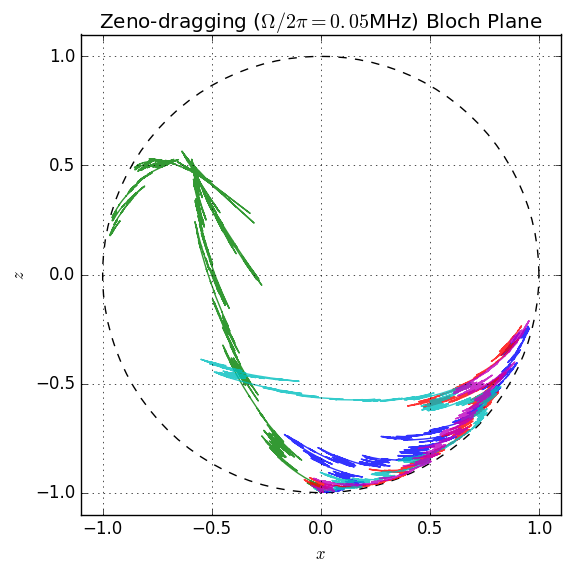

In [12]:
plot_solution([[sols[1](k), sols[2](k), sols[3](k)] for k in 1:sols[1].n], bloch=false, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz)")

#### Double-channel drag, 50kHz, $\phi=0$

INFO: Trajectory: steps = 4999, points = 4999, values = 2
INFO: Readout: values = 2


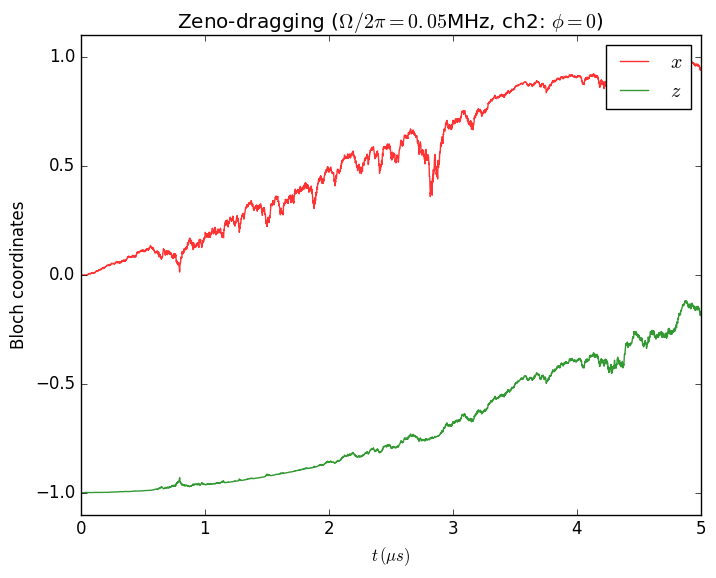

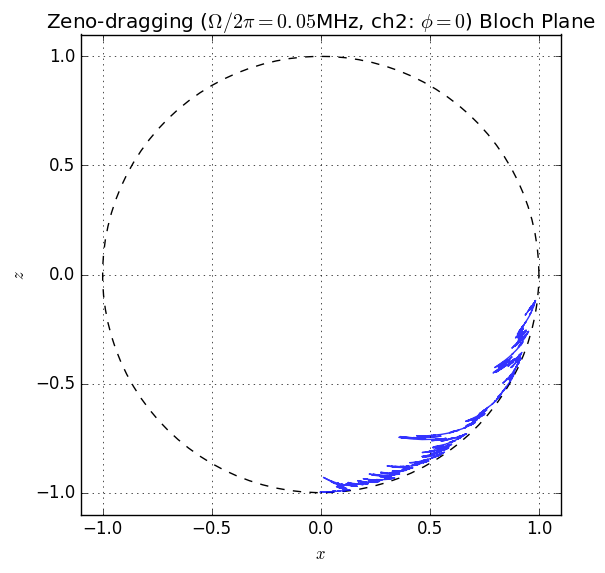

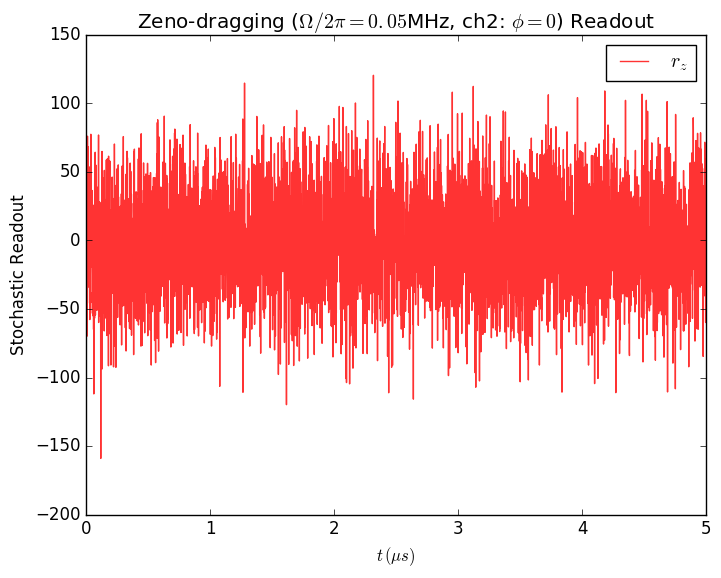

INFO: Time elapsed: 3.144196684 s, Steps per second: 1589.9132600192004


In [13]:
sols = ensemble_realization(2π*0.05, n=1, T=(0.0, 5.0), ch2=true);
plot_solution([sols], readout=true, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz, ch2: $\phi=0$)")

In [14]:
sols = ensemble_realization(2π*0.05, n=5, T=(0.0, 5.0), ch2=true);

INFO: Trajectories: 5, steps each: 4999, points each: 4999, values each = 2
INFO: Readouts: values each = 2
INFO: Time elapsed: 7.438509798 s, Steps: 24995, Steps per second: 3360.21604847794


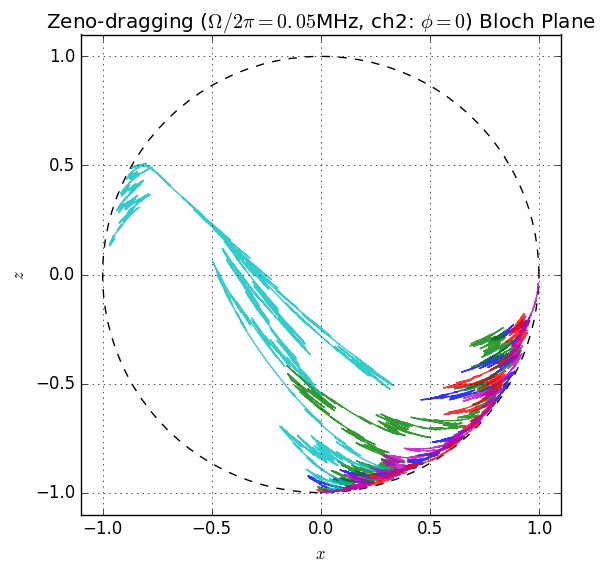

In [15]:
plot_solution([[sols[1](k), sols[2](k), sols[3](k)] for k in 1:sols[1].n], bloch=false, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz, ch2: $\phi=0$)")

#### Double-channel drag, 50kHz, $\phi=\pi/6$

INFO: Trajectory: steps = 4999, points = 4999, values = 2
INFO: Readout: values = 2


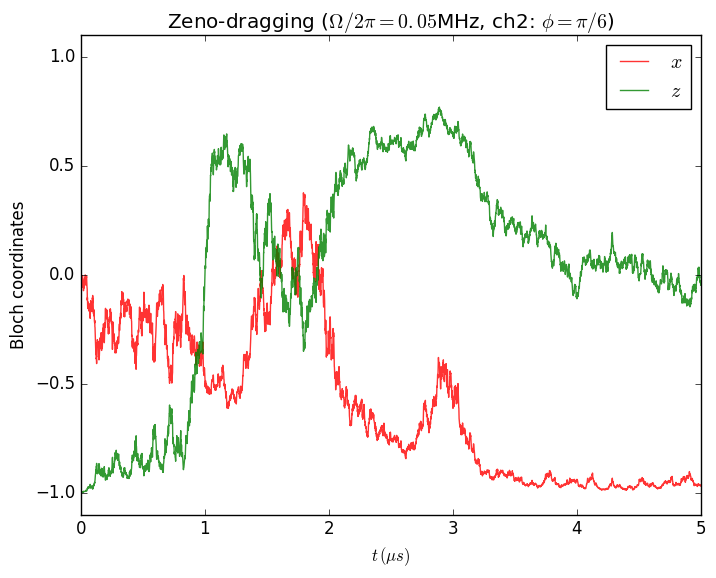

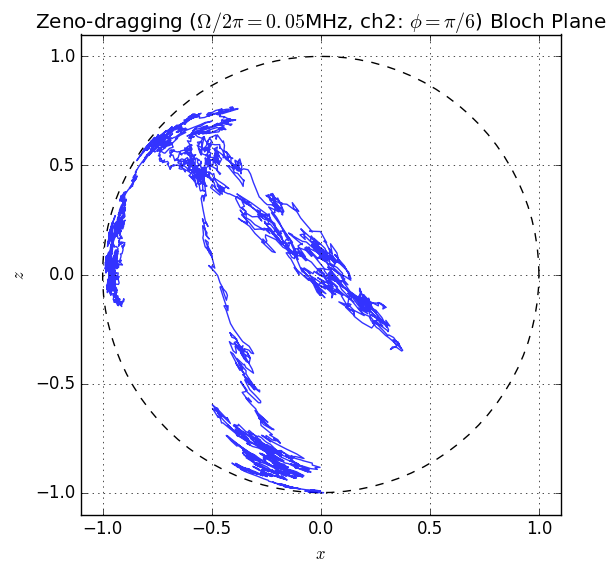

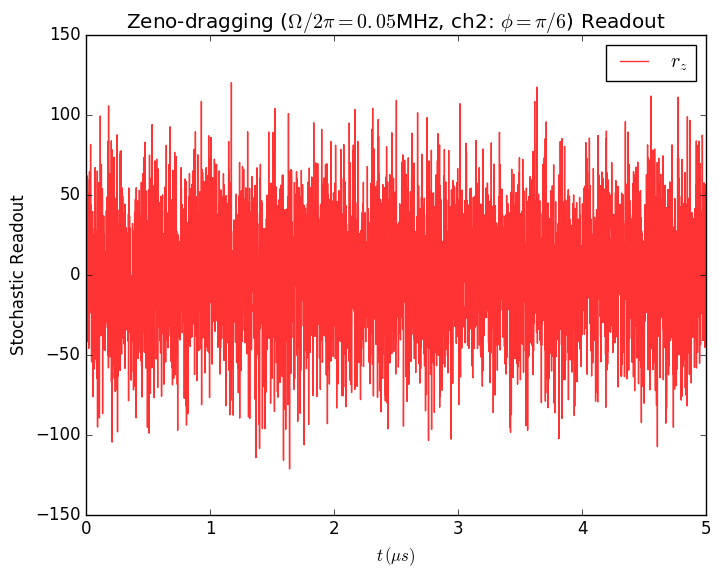

INFO: Time elapsed: 3.071135272 s, Steps per second: 1627.7368325572083


In [16]:
sols = ensemble_realization(2π*0.05, n=1, T=(0.0, 5.0), ch2=true, ϕ=π/6);
plot_solution([sols], readout=true, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz, ch2: $\phi=\pi/6$)")

In [17]:
sols = ensemble_realization(2π*0.05, n=5, T=(0.0, 5.0), ch2=true, ϕ=π/6);

INFO: Trajectories: 5, steps each: 4999, points each: 4999, values each = 2
INFO: Readouts: values each = 2
INFO: Time elapsed: 4.461995262 s, Steps: 24995, Steps per second: 5601.754043278946


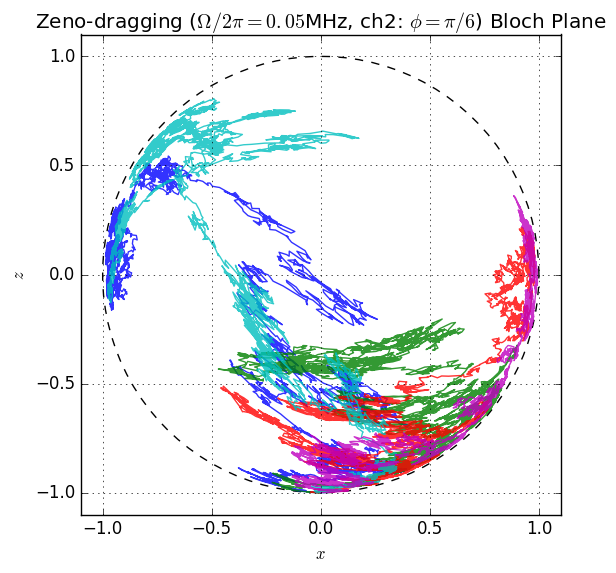

In [18]:
plot_solution([[sols[1](k), sols[2](k), sols[3](k)] for k in 1:sols[1].n], bloch=false, plot_title=L"Zeno-dragging ($\Omega/2\pi = 0.05$MHz, ch2: $\phi=\pi/6$)")

### Ensembles of trajectories

#### Reference ensemble averages

First we plot the reference Lindblad solutions that an ensemble should average to ($50$kHz drag, $4\mu$s duration):

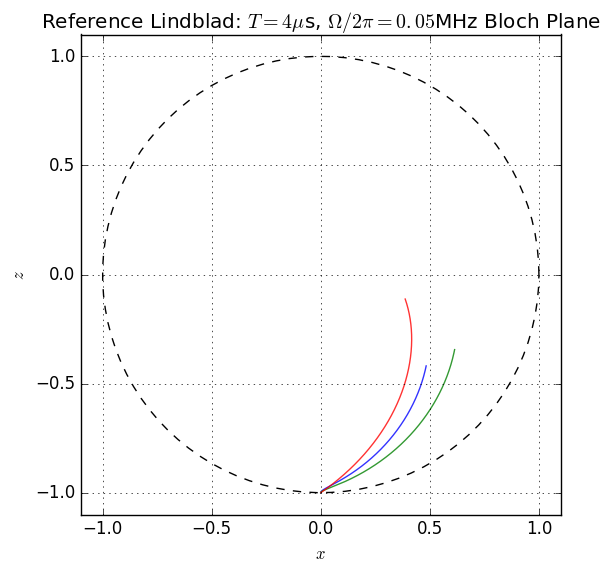

In [19]:
sols = ensemble_average(2π*0.05, T=(0.0, 4.0), verbose=false)
sols2 = ensemble_average(2π*0.05, T=(0.0, 4.0), verbose=false, ch2=true)
sols3 = ensemble_average(2π*0.05, T=(0.0, 4.0), verbose=false, ch2=true, ϕ=π/6)
plot_solution([sols,sols2,sols3], bloch=false, plot_title=L"Reference Lindblad: $T=4\mu$s, $\Omega/2\pi=0.05$MHz")

Next we compute trajectory ensembles and compare.

##### Single-channel drag

In [20]:
# Ensemble size, for easy tunability
ntraj = 5000;

In [21]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0));

INFO: Trajectories: 5000, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 1
INFO: Time elapsed: 1879.434413379 s, Steps: 19995000, Steps per second: 10638.83892817061


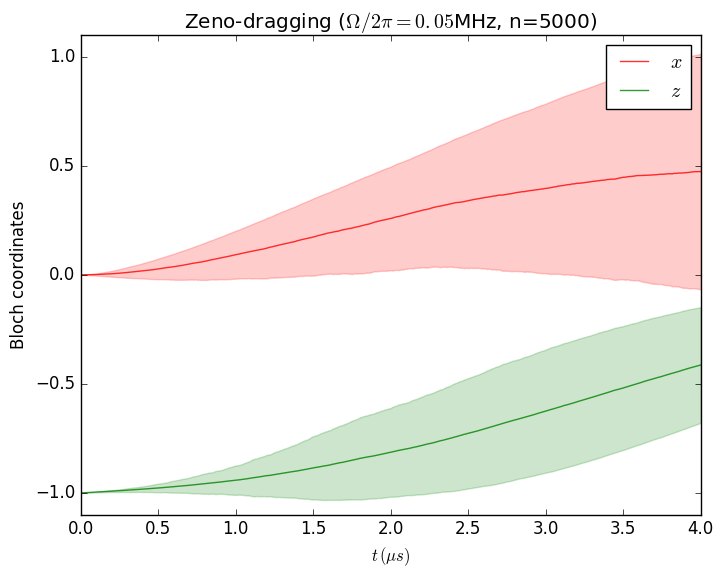

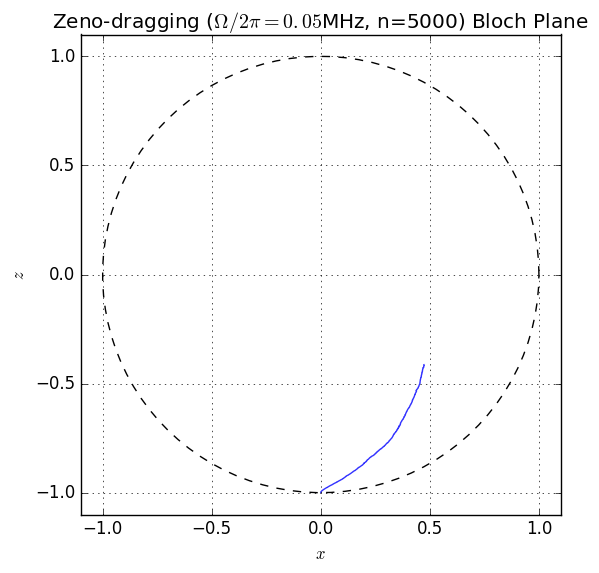

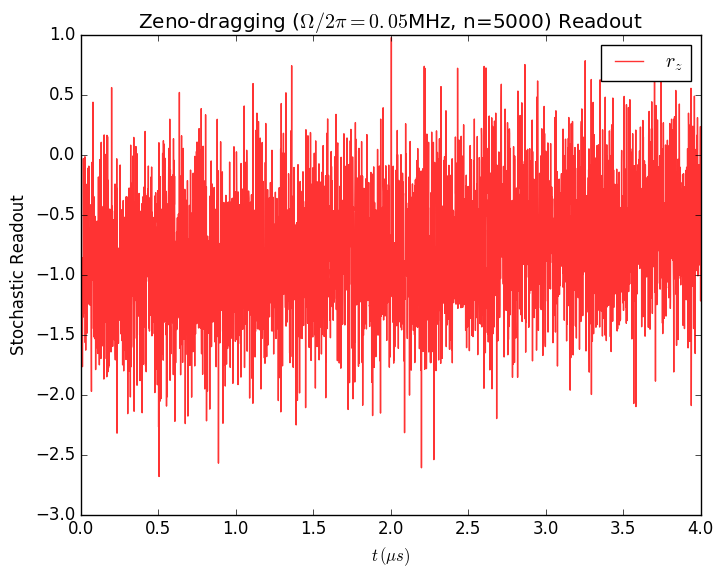

In [22]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj)"))

In [23]:
save("ensemble-1ch.jld", "x", sols[1], "z", sols[2], "r", sols[3])

##### Two-channel drag, $\phi=0$

In [36]:
# Ensemble size, for easy tunability
ntraj = 5000;

In [37]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0), ch2=true);

INFO: Trajectories: 5000, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 2
INFO: Time elapsed: 3162.689480392 s, Steps: 19995000, Steps per second: 6322.15085419063


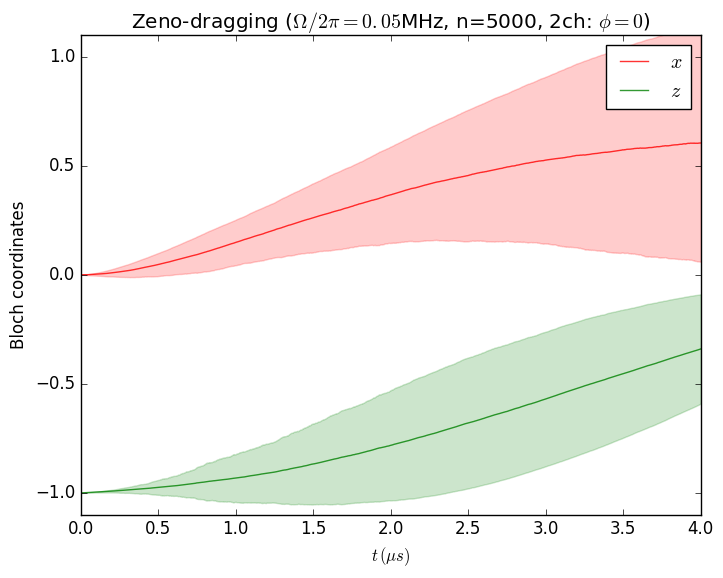

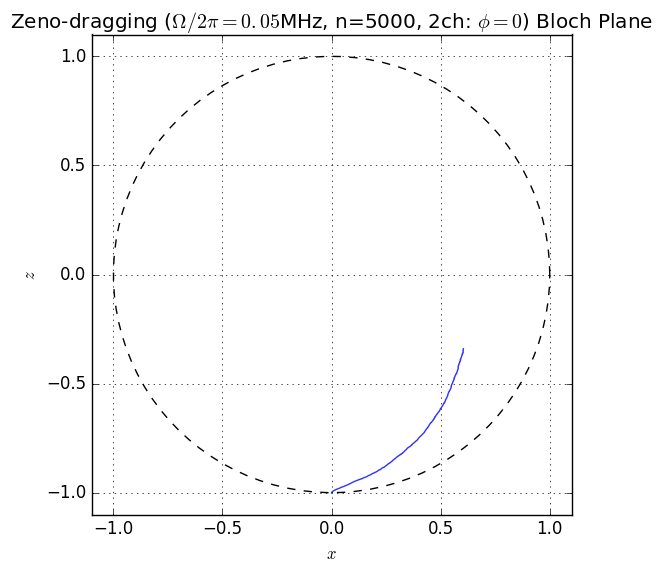

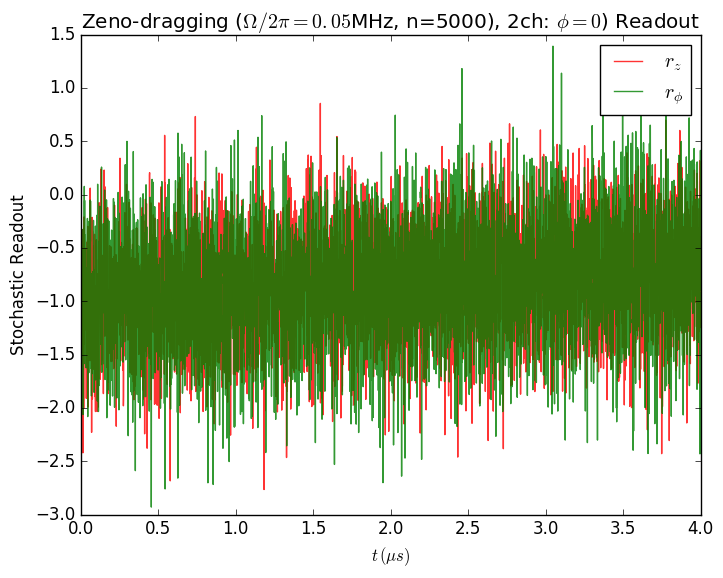

In [38]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj, 2ch: \$\\phi=0\$)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, ch2=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj), 2ch: \$\\phi=0\$)"))

In [39]:
save("ensemble-2ch-phi0.jld", "x", sols[1], "z", sols[2], "rz", sols[3], "rphi", sols[4])

##### Two-channel drag, $\phi=\pi/6$

In [40]:
# Ensemble size, for easy tunability
ntraj = 5000;

In [41]:
sols = ensemble_realization(2π*0.05, n=ntraj, T=(0.0, 4.0), ch2=true, ϕ=π/6);

INFO: Trajectories: 5000, steps each: 3999, points each: 3999, values each = 2
INFO: Readouts: values each = 2
INFO: Time elapsed: 3094.176950358 s, Steps: 19995000, Steps per second: 6462.138501059726


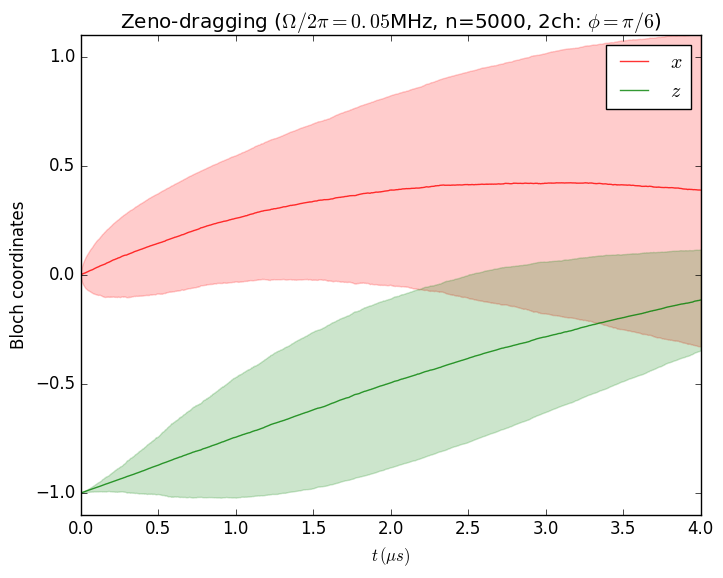

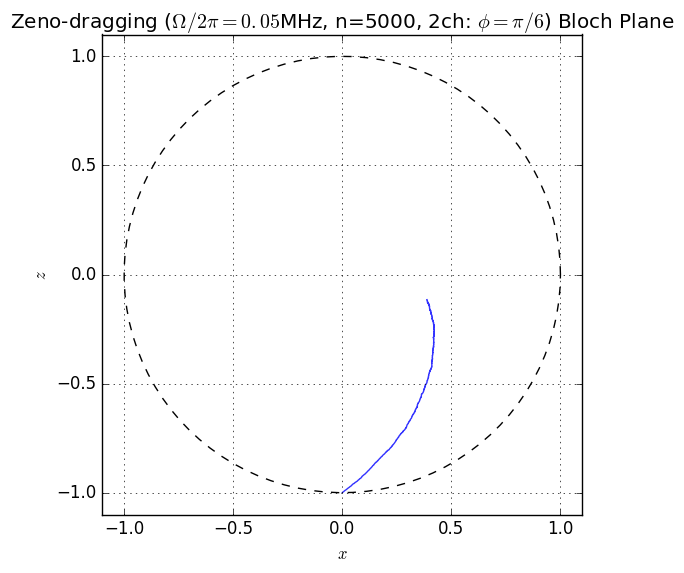

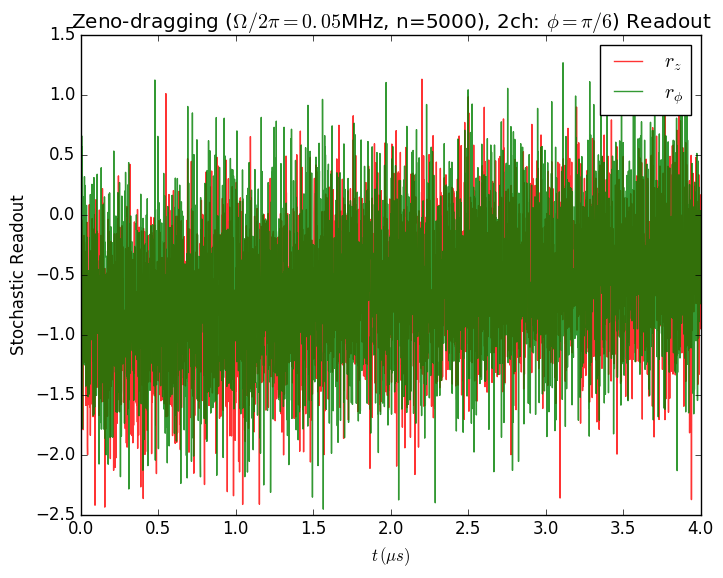

In [42]:
plot_solution([map(mean, sols)], stds=map(std, sols), plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj, 2ch: \$\\phi=\\pi/6\$)"))
plot_solution([map(mean, sols)], bloch=false, blochplane=false, readout=true, ch2=true, plot_title=latexstring("Zeno-dragging (\$\\Omega/2\\pi = 0.05\$MHz, n=$ntraj), 2ch: \$\\phi=\\pi/6\$)"))

In [43]:
save("ensemble-2ch-phi30deg.jld", "x", sols[1], "z", sols[2], "rz", sols[3], "rphi", sols[4])

## Version Information

In [44]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas
  LIBM: libm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


In [45]:
Pkg.installed("PyPlot")

v"2.2.4"

In [46]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"

In [47]:
Pkg.installed("Interpolations")

v"0.3.6"